In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr


In [44]:
def calc_water_transport_CS(vel_component, x_slice, y_slice, z_slice, spacing,timeslice, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_slice  : slice or index of cross-section in vertical direction
    spacing: xarray (nx,ny), width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice,Z=z_slice,T=timeslice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))
    
    waterCS_flux = (vel_CS*dx_CS).sum(dim=dim_name)
    
    return waterCS_flux

def calc_water_transport_AS(vel_component, x_slice, y_slice, z_slice, spacing,dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_slice  : slice or index of cross-section in vertical direction
    spacing: xarray (nx,ny), width of cross section elements (e.g. dyG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Y=y_slice, Xp1=x_slice,Z=z_slice))
    dx_CS = (spacing.isel(Y=y_slice, X=x_slice))
    
    waterCS_flux = (vel_CS*dx_CS).sum(dim=dim_name)
    
    return waterCS_flux

def calc_ssh_correction_AS(vel_component, x_slice, y_slice, eta,spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_slice  : slice or index of cross-section in vertical direction
    spacing: xarray (nx,ny), width of cross section elements (e.g. dyG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Y=y_slice, Xp1=x_slice,Z=0))
    dx_CS = (spacing.isel(Y=y_slice, X=x_slice))
    eta_CS = eta.isel(Y=y_slice, X=x_slice)
    surface_flux = (vel_CS*dx_CS*eta_CS).sum(dim=dim_name)
    
    return (surface_flux)

def calc_ssh_correction_CS(vel_component, x_slice, y_slice, eta, spacing, dim_name):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.V)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_slice  : slice or index of cross-section in vertical direction
    spacing: xarray (nx,ny), width of cross section elements (e.g. dyG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice,Z=0))
    dx_CS = (spacing.isel(Y=y_slice, X=x_slice))
    eta_CS = eta.isel(Y=y_slice, X=x_slice)
    surface_flux = (vel_CS*dx_CS*eta_CS).sum(dim=dim_name)
    
    return (surface_flux)

def calc_water_transport_Vert(vel_component, x_slice, y_slice,z_index,t_slice, area):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. state38.W)
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    z_index : vertical index to set horizontal section
    area: xarray, area of each cell in the cross section (grid.rA)
    dim_name: str, name of the dimension along which to sum.
    
    RETURNS:
    Time series of vertical transport through the section.
    '''
    vel_vert = (vel_component.isel(Y=y_slice, X=x_slice, Zl=z_index,T=t_slice))
    area_section = (area.isel(Y=y_slice, X=x_slice))

    waterVert_flux = ((area_section*vel_vert).sum(dim='Y')).sum(dim='X')

    return waterVert_flux


def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('tracer transport [$Mol/l.m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)
    

### Load files

In [62]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_file_NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'

grid = xr.open_dataset(grid_file)
grid_NoC = xr.open_dataset(grid_file_NoC)

## 
flux_file38 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
flux_file42 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc'

flux_file37 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run37/stateGlob.nc'
flux_file36 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run36/stateGlob.nc'
flux_file44 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run44/stateGlob.nc'
flux_file45 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run45/stateGlob.nc'
flux_file46 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run46/stateGlob.nc'
flux_file43 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run43/stateGlob.nc'
flux_file45 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run45/stateGlob.nc'
flux_file48 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run48/stateGlob.nc'

flux_file51 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run51/stateGlob.nc'
flux_file52 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run52/stateGlob.nc'

flux_file53 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run53/stateGlob.nc'
flux_file41 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run41/stateGlob.nc'
flux_file40 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40/stateGlob.nc'
flux_file47 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run47/stateGlob.nc'
flux_file48 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run48/stateGlob.nc'
flux_file49 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run49/stateGlob.nc'
flux_file50 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run50/stateGlob.nc'
flux_file54 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run54/stateGlob.nc'

flux_file55 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run55/stateGlob.nc'
flux_file56 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run56/stateGlob.nc'
flux_file57 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run57/stateGlob.nc'
flux_file58 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run58/stateGlob.nc'
flux_file59 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run59/stateGlob.nc'
flux_file60 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run60/stateGlob.nc'

flux_file61 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run61/stateGlob.nc'
flux_file62 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run62/stateGlob.nc'
flux_file63 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run63/stateGlob.nc'
flux_file64 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run64/stateGlob.nc'
flux_file65 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run65/stateGlob.nc'
flux_file66 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run66/stateGlob.nc'

flux_file67 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run67/stateGlob.nc'
flux_file68 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run68/stateGlob.nc'
flux_file69 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run69/stateGlob.nc'
flux_file70 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run70/stateGlob.nc'
flux_file71 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run71/stateGlob.nc'
flux_file72 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run72/stateGlob.nc'

flux_file73 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run73/stateGlob.nc'
#flux_file74 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run74/stateGlob.nc'
flux_file75 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run75/stateGlob.nc'
flux_file76 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run76/stateGlob.nc'

flux_file013D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run01/stateGlob.nc'
flux_file023D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run02/stateGlob.nc'
flux_file033D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03/stateGlob.nc'
flux_file043D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run04/stateGlob.nc'

flux_file043DDiff = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/stateGlob.nc'
flux_file053DDiff = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/stateGlob.nc'
flux_file063DDiff = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/stateGlob.nc'
flux_file073DDiff = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/stateGlob.nc'

flux_file05 = '/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run05/stateGlob.nc'
flux_file06 = '/ocean/kramosmu/MITgcm/TracerExperiments/EW_OBCS/run06/stateGlob.nc'

flux_file01 = '/ocean/kramosmu/MITgcm/TracerExperiments/LESS_BF/run01/stateGlob.nc'
flux_file02 = '/ocean/kramosmu/MITgcm/TracerExperiments/LESS_BF/run02/stateGlob.nc'


In [64]:
flux38 = xr.open_dataset(flux_file38) 
flux37 = xr.open_dataset(flux_file37)  
flux36 = xr.open_dataset(flux_file36)  
#flux44 = xr.open_dataset(flux_file44)  
flux45 = xr.open_dataset(flux_file45)  
#flux46 = xr.open_dataset(flux_file46)  
flux43 = xr.open_dataset(flux_file43)  
flux51 = xr.open_dataset(flux_file51)  
flux52 = xr.open_dataset(flux_file52)  

flux41 = xr.open_dataset(flux_file41)  
flux42 = xr.open_dataset(flux_file42)
flux40 = xr.open_dataset(flux_file40)  
#flux47 = xr.open_dataset(flux_file47)  
flux48 = xr.open_dataset(flux_file48)  
#flux49 = xr.open_dataset(flux_file49)  
flux50 = xr.open_dataset(flux_file50)  
flux53 = xr.open_dataset(flux_file53)  
flux54 = xr.open_dataset(flux_file54)  

flux55 = xr.open_dataset(flux_file55)  
flux56 = xr.open_dataset(flux_file56)  
flux57 = xr.open_dataset(flux_file57)  
flux58 = xr.open_dataset(flux_file58)  
flux59 = xr.open_dataset(flux_file59)  
flux60 = xr.open_dataset(flux_file60)  

flux61 = xr.open_dataset(flux_file61)  
flux62 = xr.open_dataset(flux_file62)  
flux63 = xr.open_dataset(flux_file63)  
flux64 = xr.open_dataset(flux_file64)  
flux65 = xr.open_dataset(flux_file65)  
flux66 = xr.open_dataset(flux_file66)  

flux67 = xr.open_dataset(flux_file67)  
flux68 = xr.open_dataset(flux_file68)  
flux69 = xr.open_dataset(flux_file69)  
flux70 = xr.open_dataset(flux_file70)  
flux71 = xr.open_dataset(flux_file71)  
flux72 = xr.open_dataset(flux_file72)  
flux73 = xr.open_dataset(flux_file73)  
#flux74 = xr.open_dataset(flux_file74)  
flux75 = xr.open_dataset(flux_file75)  
flux76 = xr.open_dataset(flux_file76)  

flux013D = xr.open_dataset(flux_file013D) 
flux023D = xr.open_dataset(flux_file023D) 
flux033D = xr.open_dataset(flux_file033D) 
flux043D = xr.open_dataset(flux_file043D)

flux043DDiff = xr.open_dataset(flux_file043DDiff) 
flux053DDiff = xr.open_dataset(flux_file053DDiff) 
flux063DDiff = xr.open_dataset(flux_file063DDiff) 
flux073DDiff = xr.open_dataset(flux_file073DDiff)

flux05 = xr.open_dataset(flux_file05)  
flux06 = xr.open_dataset(flux_file06)  

flux01 = xr.open_dataset(flux_file01)  
flux02 = xr.open_dataset(flux_file02)  


In [7]:
# Define slices and indices of cross-shelf wall
CS_x_slice = slice(2, 358)
CS_y_ind = 230
CS_z_slice = slice(0,35)

# Define slices and indices of coast wall
Coast_x_slice = slice(2, 358)
Coast_y_ind = 357
Coast_z_slice = slice(0,35)

# Define slices and indices of E and W boundaries
W_x_ind = 2
E_x_ind = 358
Bdy_y_slice = slice(230,357)
Bdy_z_slice = slice(0,35)

# Define horizontal plane over canyon 
Vert_x_slice = slice(120, 241)
Vert_y_slice= slice(227,268)
z_ind = 30

# Define time interval to average over (advective phase is from 8 to 19)
time_slice = slice(8,20) 

In [8]:
# base case Transport = sum(sum(U*dx*dz))
#advCS_flux38 = ((calc_water_transport_CS(flux38.V,
#                                       CS_x_slice, CS_y_ind,CS_z_slice,
#                                       grid.dxG,'X'))*grid.drF.isel(Z=CS_z_slice)).sum(dim='Z')
advCS_flux42 = ((calc_water_transport_CS(flux42.V, 
                                      CS_x_slice, CS_y_ind,CS_z_slice,
                                      grid_NoC.dxF,'X'))*grid_NoC.drF.isel(Z=CS_z_slice)).sum(dim='Z')


In [9]:
# base case Transport = sum(sum(U*dx*dz))
advCoast_flux38 = ((calc_water_transport_CS(flux38.V,
                                       Coast_x_slice, Coast_y_ind,Coast_z_slice,
                                       grid.dxF,'X'))*grid.drF.isel(Z=Coast_z_slice)).sum(dim='Z')
advCoast_flux42 = ((calc_water_transport_CS(flux42.V, 
                                      Coast_x_slice, Coast_y_ind,Coast_z_slice,
                                      grid_NoC.dxF,'X'))*grid_NoC.drF.isel(Z=Coast_z_slice)).sum(dim='Z')


In [10]:
# base case Transport = sum(sum(U*dx*dz))
advE_flux42 = ((calc_water_transport_AS(flux42.U,
                                       E_x_ind, Bdy_y_slice,Bdy_z_slice,
                                       grid.dyF,'Y'))*grid_NoC.drF.isel(Z=Bdy_z_slice)).sum(dim='Z')
advW_flux42 = ((calc_water_transport_AS(flux42.U, 
                                      W_x_ind, Bdy_y_slice,Bdy_z_slice,
                                      grid_NoC.dyF,'Y'))*grid_NoC.drF.isel(Z=Bdy_z_slice)).sum(dim='Z')


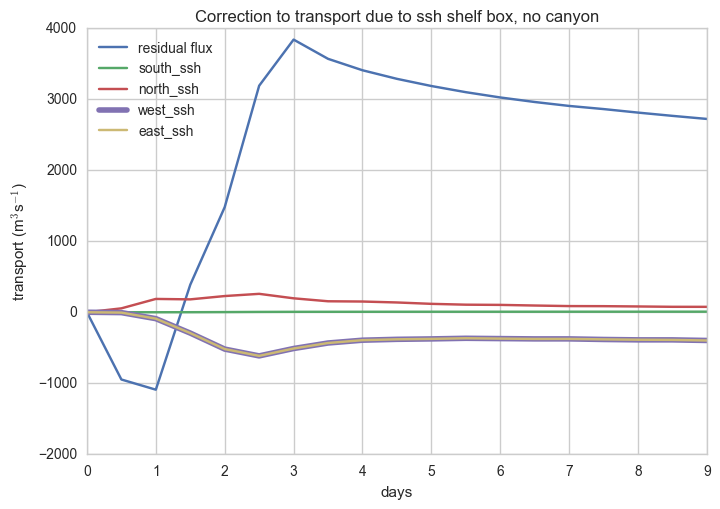

In [11]:

#top cells transport correction:
south_ssh = calc_ssh_correction_CS(flux42.V, CS_x_slice, CS_y_ind, flux42.Eta,grid_NoC.dxF, 'X')
north_ssh = calc_ssh_correction_CS(flux42.V, Coast_x_slice, Coast_y_ind, flux42.Eta,grid_NoC.dxF, 'X')
west_ssh = calc_ssh_correction_AS(flux42.U, W_x_ind, Bdy_y_slice, flux42.Eta,grid_NoC.dyF, 'Y')
east_ssh = calc_ssh_correction_AS(flux42.U, E_x_ind, Bdy_y_slice, flux42.Eta,grid_NoC.dyF, 'Y')

sns.set_context('notebook')
sns.set_style('whitegrid')

plt.plot(np.arange(19)/2.0,(advW_flux42)-
         (advE_flux42) +
         (advCS_flux42)-
         (advCoast_flux42)
         ,label='residual flux')

plt.plot(np.arange(19)/2,south_ssh,label='south_ssh')
plt.plot(np.arange(19)/2,north_ssh,label='north_ssh')
plt.plot(np.arange(19)/2,west_ssh,label='west_ssh',linewidth=4)
plt.plot(np.arange(19)/2,east_ssh,label='east_ssh')

plt.title('Correction to transport due to ssh shelf box, no canyon')
plt.ylabel('transport (m$^3$s$^{-1}$)')
plt.xlabel('days')
plt.legend(loc=0)

In [24]:
advCS_flux38 = calc_water_transport_CS(unstagger_xarray(flux38.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux42 = calc_water_transport_CS(unstagger_xarray(flux42.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')


In [18]:

# diffusivity and viscosity

advCS_flux36 = calc_water_transport_CS(unstagger_xarray(flux36.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux37 = calc_water_transport_CS(unstagger_xarray(flux37.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux43 = calc_water_transport_CS(unstagger_xarray(flux43.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

advCS_flux013D = calc_water_transport_CS(unstagger_xarray(flux013D.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux023D = calc_water_transport_CS(unstagger_xarray(flux023D.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux033D = calc_water_transport_CS(unstagger_xarray(flux033D.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux043D = calc_water_transport_CS(unstagger_xarray(flux043D.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')


advCS_flux40 = calc_water_transport_CS(unstagger_xarray(flux40.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux41 = calc_water_transport_CS(unstagger_xarray(flux41.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux50 = calc_water_transport_CS(unstagger_xarray(flux50.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')



In [19]:
# diffusivity only 
advCS_flux61 = calc_water_transport_CS(unstagger_xarray(flux61.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux62 = calc_water_transport_CS(unstagger_xarray(flux62.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux63 = calc_water_transport_CS(unstagger_xarray(flux63.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

advCS_flux043DDiff = calc_water_transport_CS(unstagger_xarray(flux043DDiff.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux053DDiff = calc_water_transport_CS(unstagger_xarray(flux053DDiff.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux063DDiff = calc_water_transport_CS(unstagger_xarray(flux063DDiff.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux073DDiff = calc_water_transport_CS(unstagger_xarray(flux073DDiff.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

advCS_flux64 = calc_water_transport_CS(unstagger_xarray(flux64.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux65 = calc_water_transport_CS(unstagger_xarray(flux65.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux66 = calc_water_transport_CS(unstagger_xarray(flux66.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')



In [20]:
# Viscosity only
advCS_flux55 = calc_water_transport_CS(unstagger_xarray(flux55.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux56 = calc_water_transport_CS(unstagger_xarray(flux56.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux57 = calc_water_transport_CS(unstagger_xarray(flux57.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

advCS_flux58 = calc_water_transport_CS(unstagger_xarray(flux58.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux59 = calc_water_transport_CS(unstagger_xarray(flux59.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux60 = calc_water_transport_CS(unstagger_xarray(flux60.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')



In [21]:
# Burger number
##advCS_flux44 = calc_water_transport_CS(unstagger_xarray(flux44.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux45 = calc_water_transport_CS(unstagger_xarray(flux45.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
##advCS_flux46 = calc_water_transport_CS(unstagger_xarray(flux46.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux51 = calc_water_transport_CS(unstagger_xarray(flux51.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux52 = calc_water_transport_CS(unstagger_xarray(flux52.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux67 = calc_water_transport_CS(unstagger_xarray(flux67.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux69 = calc_water_transport_CS(unstagger_xarray(flux69.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux71 = calc_water_transport_CS(unstagger_xarray(flux71.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
#advCS_flux73 = calc_water_transport_CS(unstagger_xarray(flux73.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux75 = calc_water_transport_CS(unstagger_xarray(flux75.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

##advCS_flux47 = calc_water_transport_CS(unstagger_xarray(flux47.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux48 = calc_water_transport_CS(unstagger_xarray(flux48.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
##advCS_flux49 = calc_water_transport_CS(unstagger_xarray(flux49.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux53 = calc_water_transport_CS(unstagger_xarray(flux53.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux54 = calc_water_transport_CS(unstagger_xarray(flux54.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux68 = calc_water_transport_CS(unstagger_xarray(flux68.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux70 = calc_water_transport_CS(unstagger_xarray(flux70.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux72 = calc_water_transport_CS(unstagger_xarray(flux72.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
#advCS_flux74 = calc_water_transport_CS(unstagger_xarray(flux74.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux76 = calc_water_transport_CS(unstagger_xarray(flux76.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')


In [22]:
advCS_flux05 = calc_water_transport_CS(unstagger_xarray(flux05.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux06 = calc_water_transport_CS(unstagger_xarray(flux06.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

advCS_flux01 = calc_water_transport_CS(unstagger_xarray(flux01.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')
advCS_flux02 = calc_water_transport_CS(unstagger_xarray(flux02.V,'Yp1'), CS_x_slice, CS_y_ind,CS_z_slice, unstagger_xarray(grid.dxG,'Yp1'), time_slice, 'X').sum(dim='Z')

## Diffusivity only

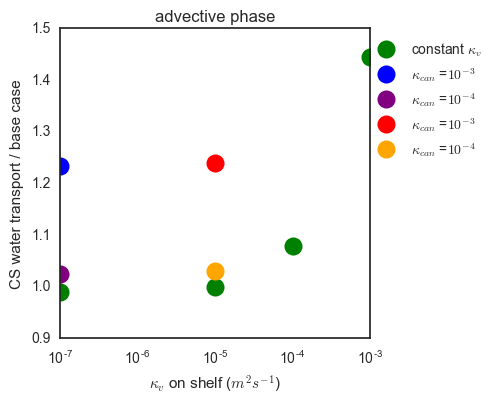

In [25]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$'
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advCS_flux61-advCS_flux64 ,advCS_flux38-advCS_flux42 ,advCS_flux62-advCS_flux65 ,advCS_flux63-advCS_flux66 ,
             advCS_flux043DDiff-advCS_flux64 ,advCS_flux053DDiff-advCS_flux64 ,
             advCS_flux063DDiff-advCS_flux42 ,advCS_flux073DDiff-advCS_flux42 ,
             ]

base = advCS_flux38-advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase')

ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
fig.savefig('advCS_WatTrans_canyon_effect_diffusivity_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


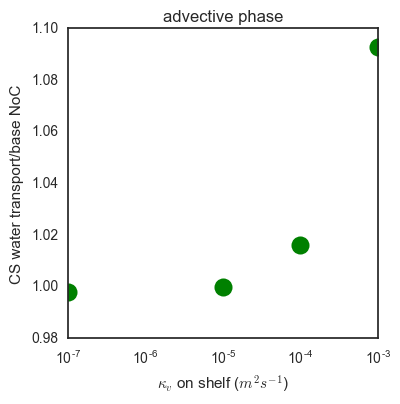

In [26]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v$']

colors = ['green','green','green','green']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advCS_flux64 ,advCS_flux42 ,advCS_flux65 ,advCS_flux66]
base = advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport/base NoC')
ax.set_title('advective phase')

fig.savefig('advCS_WatTrans_NoC_diffusivity_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


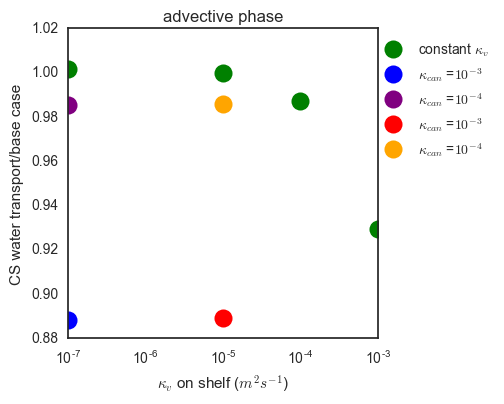

In [27]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$'
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advCS_flux61 ,advCS_flux38 ,advCS_flux62 ,advCS_flux63,
             advCS_flux043DDiff ,advCS_flux053DDiff,
             advCS_flux063DDiff ,advCS_flux073DDiff ,
             ]

base = advCS_flux38
fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport/base case')
ax.set_title('advective phase')

ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
fig.savefig('advCS_WatTrans_canyon_diffusivity_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Diffusivity and viscosity

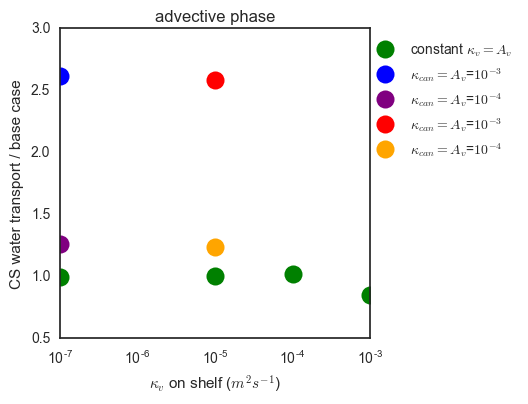

In [28]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v=A_v$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advCS_flux43-advCS_flux50 ,
              advCS_flux38-advCS_flux42 ,
              advCS_flux37-advCS_flux41 ,
              advCS_flux36-advCS_flux40,
              advCS_flux013D-advCS_flux50,
              advCS_flux023D-advCS_flux50,
              advCS_flux033D-advCS_flux42,
              advCS_flux043D-advCS_flux42 ,
              ]
base = advCS_flux38-advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('advCS_WatTrans_canyon_effect_Kv_and_Av.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


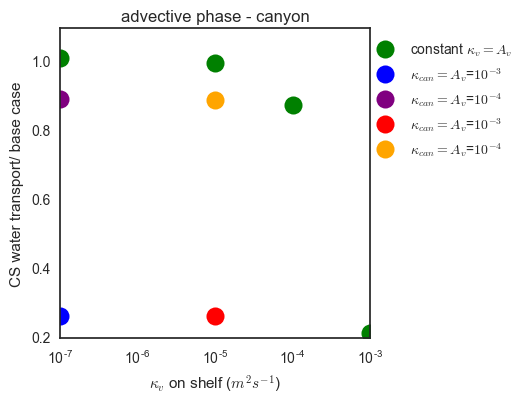

In [29]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v=A_v$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advCS_flux43,
              advCS_flux38,
              advCS_flux37,
              advCS_flux36,
              advCS_flux013D,
              advCS_flux023D,
              advCS_flux033D,
              advCS_flux043D,
              ]

base = advCS_flux38

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport/ base case')
ax.set_title('advective phase - canyon')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('advCS_WatTrans_canyon_Kv_and_Av.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


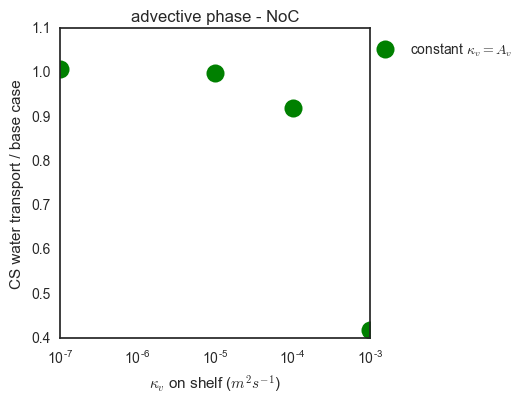

In [30]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v=A_v$']

colors = ['green','green','green','green']

kv = [1E-7,1E-5,1E-4,1E-3]

trans_list = [advCS_flux50,
              advCS_flux42,
              advCS_flux41,
              advCS_flux40,
             ]

base = advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase - NoC')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('advCS_WatTrans_NoC_Kv_and_Av.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Viscosity only

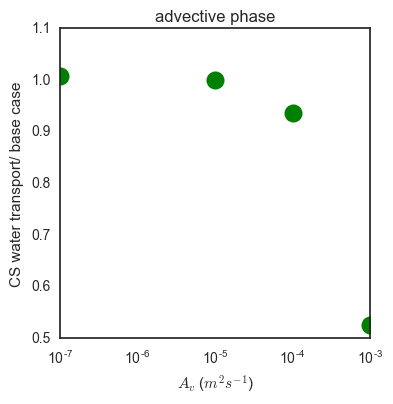

In [31]:
sns.set_context('notebook')
sns.set_style('white')


Av = [1E-7,1E-5,1E-4,1E-3]

trans_list = [advCS_flux55-advCS_flux58 ,
              advCS_flux38-advCS_flux42 ,
              advCS_flux56-advCS_flux59 ,
              advCS_flux57-advCS_flux60,
              ]

base = advCS_flux38-advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Av_num in zip(trans_list,Av):
    ax.plot(Av_num,trans[:].mean()/base[:].mean(),'go', markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$A_v$ ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport/ base case')
ax.set_title('advective phase')

fig.savefig('advCS_WatTrans_canyon_effect_Av_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


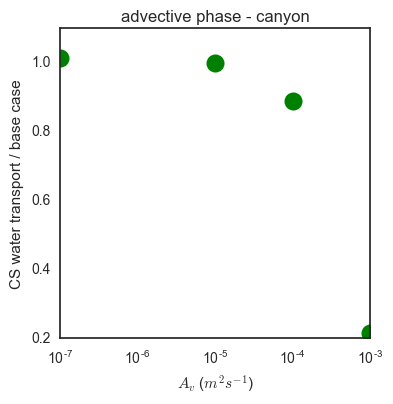

In [32]:
sns.set_context('notebook')
sns.set_style('white')


Av = [1E-7,1E-5,1E-4,1E-3]

trans_list = [advCS_flux55 ,
              advCS_flux38 ,
              advCS_flux56,
              advCS_flux57,
              ]
base = advCS_flux38
fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Av_num in zip(trans_list,Av):
    ax.plot(Av_num,trans[:].mean()/base[:].mean(),'go', markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$A_v$ ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase - canyon')

fig.savefig('advCS_WatTrans_canyon_Av_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


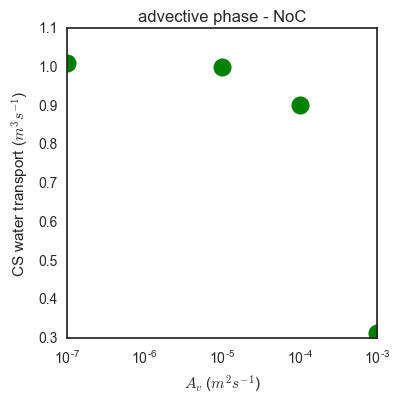

In [33]:
sns.set_context('notebook')
sns.set_style('white')


Av = [1E-7,1E-5,1E-4,1E-3]

trans_list = [advCS_flux58 ,
              advCS_flux42 ,
              advCS_flux59 ,
              advCS_flux60,
              ]
base = advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Av_num in zip(trans_list,Av):
    ax.plot(Av_num,trans[:].mean()/base[:].mean(),'go', markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$A_v$ ($m^2s^{-1}$)')
ax.set_ylabel('CS water transport ($m^3s^{-1}$)')
ax.set_title('advective phase - NoC')

fig.savefig('advCS_WatTrans_NoC_effect_Av_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Bu

[ 1.04610991  1.19827135  1.31581012  2.08789704  0.8559081   1.01054217
  1.17504903  1.57897214]


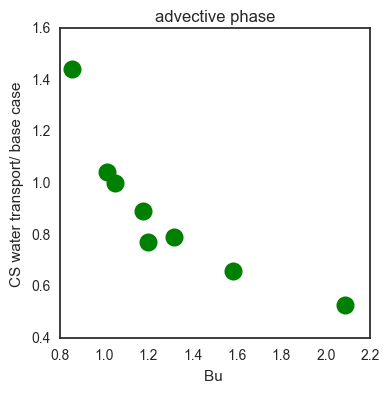

In [35]:
sns.set_context('notebook')
sns.set_style('white')

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,
              #3.9E-3,
              6.3E-3,
              #3.0E-3,
              5.5E-3,
              5.5E-3,
              #7.6E-3,
              4.5E-3,
              5.5E-3,
              5.5E-3,
              5.5E-3,
              ])

f = np.array([9.66E-5,
              #9.66E-5,
              9.66E-5,
              #9.66E-5,
              7.68E-5,
              4.84E-5,
              #9.66E-5,
              9.66E-5,
              1.0E-4,
              8.6E-5,
              6.4E-5])

Bu = (N*Hs)/(f*W)

trans_list = [advCS_flux38-advCS_flux42 ,
              #advCS_flux44-advCS_flux47 ,
              advCS_flux45-advCS_flux48 ,
              #advCS_flux46-advCS_flux49 ,
              advCS_flux51-advCS_flux53,
              advCS_flux52-advCS_flux54,
              #advCS_flux73-advCS_flux74,
              advCS_flux75-advCS_flux76,
              advCS_flux67-advCS_flux68,
              advCS_flux69-advCS_flux70,
              advCS_flux71-advCS_flux72,
              ]
base = advCS_flux38-advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Bu_num in zip(trans_list,Bu):
    ax.plot(Bu_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Bu ')
ax.set_ylabel('CS water transport/ base case')
ax.set_title('advective phase')

fig.savefig('advCS_WatTrans_canyon_effect_Bu.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')

print(Bu)


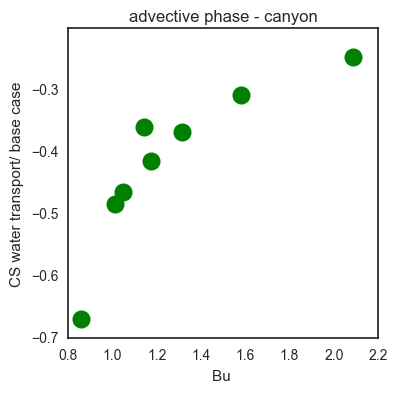

In [36]:
sns.set_context('notebook')
sns.set_style('white')

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,
              #3.9E-3,
              6.0E-3,
              #3.0E-3,
              5.5E-3,
              5.5E-3,
              #7.6E-3,
              4.5E-3,
              5.5E-3,
              5.5E-3,
              5.5E-3,
              ])

f = np.array([9.66E-5,
              #9.66E-5,
              9.66E-5,
              #9.66E-5,
              7.68E-5,
              4.84E-5,
              #9.66E-5,
              9.66E-5,
              1.0E-4,
              8.6E-5,
              6.4E-5])

Bu = (N*Hs)/(f*W)

trans_list = [advCS_flux38-advCS_flux42 ,
              #advCS_flux44-advCS_flux47 ,
              advCS_flux45-advCS_flux48 ,
              #advCS_flux46-advCS_flux49 ,
              advCS_flux51-advCS_flux53,
              advCS_flux52-advCS_flux54,
              #advCS_flux73-advCS_flux74,
              advCS_flux75-advCS_flux76,
              advCS_flux67-advCS_flux68,
              advCS_flux69-advCS_flux70,
              advCS_flux71-advCS_flux72,
              ]

base = advCS_flux38

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Bu_num in zip(trans_list,Bu):
    ax.plot(Bu_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Bu ')
ax.set_ylabel('CS water transport/ base case')
ax.set_title('advective phase - canyon')

fig.savefig('advCS_WatTrans_canyon_Bu.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


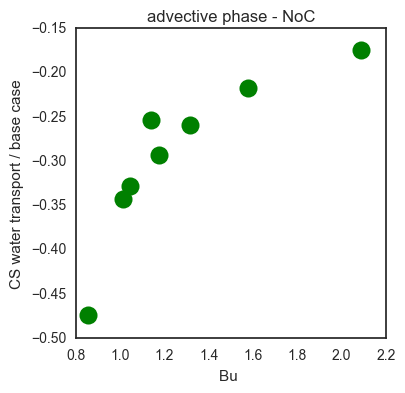

In [37]:
sns.set_context('notebook')
sns.set_style('white')

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,
              #3.9E-3,
              6.0E-3,
              #3.0E-3,
              5.5E-3,
              5.5E-3,
              #7.6E-3,
              4.5E-3,
              5.5E-3,
              5.5E-3,
              5.5E-3,
              ])

f = np.array([9.66E-5,
              #9.66E-5,
              9.66E-5,
              #9.66E-5,
              7.68E-5,
              4.84E-5,
              #9.66E-5,
              9.66E-5,
              1.0E-4,
              8.6E-5,
              6.4E-5])

Bu = (N*Hs)/(f*W)

trans_list = [advCS_flux38-advCS_flux42 ,
              #advCS_flux44-advCS_flux47 ,
              advCS_flux45-advCS_flux48 ,
              #advCS_flux46-advCS_flux49 ,
              advCS_flux51-advCS_flux53,
              advCS_flux52-advCS_flux54,
              #advCS_flux73-advCS_flux74,
              advCS_flux75-advCS_flux76,
              advCS_flux67-advCS_flux68,
              advCS_flux69-advCS_flux70,
              advCS_flux71-advCS_flux72,
              ]
base = advCS_flux48

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Bu_num in zip(trans_list,Bu):
    ax.plot(Bu_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Bu ')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase - NoC')

fig.savefig('advCS_WatTrans_NoC_Bu.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


Mean u for base case is (m$s^-1$) 0.34
Mean u for run06 is (m$s^-1$) 0.33
Mean u for run01 is (m$s^-1$) 0.31


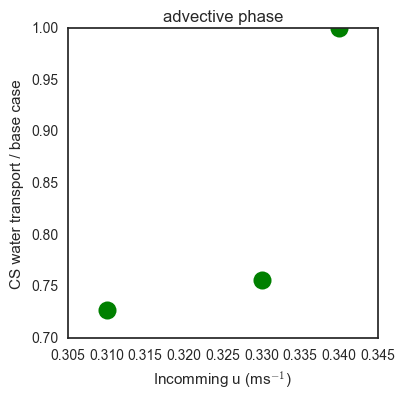

In [38]:
sns.set_context('notebook')
sns.set_style('white')

U38 = 0.34
U06 = 0.33
U01 = 0.31
u_list = [U38,U06,U01]


print('Mean u for base case is (m$s^-1$)', U38 )
print('Mean u for run06 is (m$s^-1$)', U06 )
print('Mean u for run01 is (m$s^-1$)', U01 )


trans_list = [advCS_flux38-advCS_flux42 ,
              advCS_flux06-advCS_flux05 ,
              advCS_flux01-advCS_flux02 ,
              ]

base = advCS_flux38-advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('CS water transport / base case')
ax.set_title('advective phase')

fig.savefig('advCS_WatTransport_canyon_effect_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


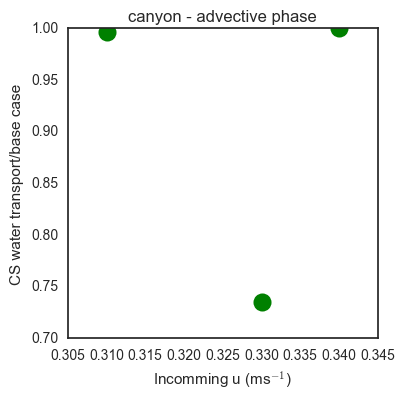

In [39]:
sns.set_context('notebook')
sns.set_style('white')

U38 = 0.34
U06 = 0.33
U01 = 0.31
u_list = [U38,U06,U01]


trans_list = [advCS_flux38 ,
              advCS_flux06 ,
              advCS_flux01 ,
              ]

base = advCS_flux38

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('CS water transport/base case')
ax.set_title('canyon - advective phase')

fig.savefig('advCS_WatTransport_canyon_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


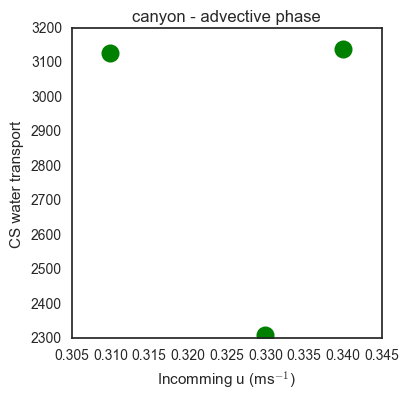

In [40]:
sns.set_context('notebook')
sns.set_style('white')

U38 = 0.34
U06 = 0.33
U01 = 0.31
u_list = [U38,U06,U01]


trans_list = [advCS_flux38 ,
              advCS_flux06 ,
              advCS_flux01 ,
              ]


fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('CS water transport')
ax.set_title('canyon - advective phase')

#fig.savefig('advCS_WatTransport_canyon_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


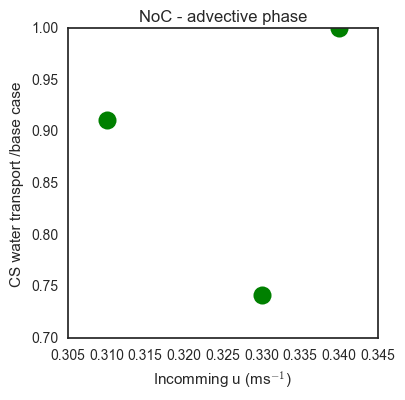

In [41]:
sns.set_context('notebook')
sns.set_style('white')


trans_list = [advCS_flux42 ,
              advCS_flux05 ,
              advCS_flux02 ,
              ]
base = advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('CS water transport /base case')
ax.set_title('NoC - advective phase')

fig.savefig('advCS_WatTransport_NoC_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


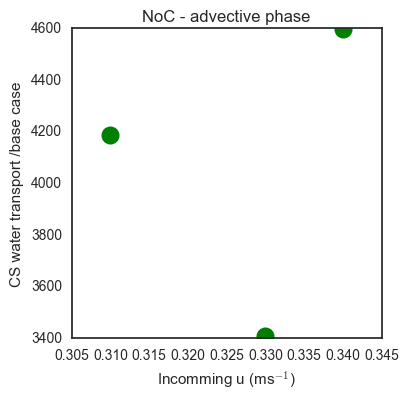

In [42]:
sns.set_context('notebook')
sns.set_style('white')


trans_list = [advCS_flux42 ,
              advCS_flux05 ,
              advCS_flux02 ,
              ]
base = advCS_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('CS water transport /base case')
ax.set_title('NoC - advective phase')



#  Vertical water transport

In [45]:
# base case
advVert_flux38 = calc_water_transport_Vert((flux38.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux42 = calc_water_transport_Vert((flux42.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)


In [46]:
advVert_flux06 = calc_water_transport_Vert((flux06.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux05 = calc_water_transport_Vert((flux05.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux01 = calc_water_transport_Vert((flux01.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux02 = calc_water_transport_Vert((flux02.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)


In [47]:
# diffusivity and viscosity
advVert_flux36 = calc_water_transport_Vert( (flux36.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux37 = calc_water_transport_Vert( (flux37.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux43 = calc_water_transport_Vert( (flux43.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux013D = calc_water_transport_Vert( (flux013D.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux023D = calc_water_transport_Vert( (flux023D.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux033D = calc_water_transport_Vert( (flux033D.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux043D = calc_water_transport_Vert( (flux043D.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux40 = calc_water_transport_Vert( (flux40.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux41 = calc_water_transport_Vert( (flux41.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux50 = calc_water_transport_Vert( (flux50.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

# diffusivity only 
advVert_flux61 = calc_water_transport_Vert( (flux61.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux62 = calc_water_transport_Vert( (flux62.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux63 = calc_water_transport_Vert( (flux63.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux043DDiff = calc_water_transport_Vert( (flux043DDiff.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux053DDiff = calc_water_transport_Vert( (flux053DDiff.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux063DDiff = calc_water_transport_Vert( (flux063DDiff.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux073DDiff = calc_water_transport_Vert( (flux073DDiff.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux64 = calc_water_transport_Vert( (flux64.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux65 = calc_water_transport_Vert( (flux65.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux66 = calc_water_transport_Vert( (flux66.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

# Viscosity only
advVert_flux55 = calc_water_transport_Vert( (flux55.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux56 = calc_water_transport_Vert( (flux56.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux57 = calc_water_transport_Vert( (flux57.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

advVert_flux58 = calc_water_transport_Vert( (flux58.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux59 = calc_water_transport_Vert( (flux59.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux60 = calc_water_transport_Vert( (flux60.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

In [65]:
# Burger number
#advVert_flux44 = calc_water_transport_Vert( (flux44.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux45 = calc_water_transport_Vert( (flux45.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
#advVert_flux46 = calc_water_transport_Vert( (flux46.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux51 = calc_water_transport_Vert( (flux51.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux52 = calc_water_transport_Vert( (flux52.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux67 = calc_water_transport_Vert( (flux67.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux69 = calc_water_transport_Vert( (flux69.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux71 = calc_water_transport_Vert( (flux71.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux73 = calc_water_transport_Vert( (flux73.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux75 = calc_water_transport_Vert( (flux75.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)

#advVert_flux47 = calc_water_transport_Vert( (flux47.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux48 = calc_water_transport_Vert( (flux48.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
#advVert_flux49 = calc_water_transport_Vert( (flux49.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux53 = calc_water_transport_Vert( (flux53.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux54 = calc_water_transport_Vert( (flux54.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux68 = calc_water_transport_Vert( (flux68.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux70 = calc_water_transport_Vert( (flux70.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux72 = calc_water_transport_Vert( (flux72.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
#advVert_flux74 = calc_water_transport_Vert( (flux74.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)
advVert_flux76 = calc_water_transport_Vert( (flux76.W), Vert_x_slice, Vert_y_slice,z_ind, time_slice, grid.rA)


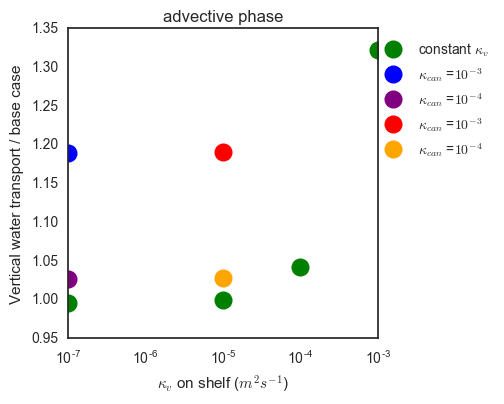

In [49]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$',
          '$\kappa_{can}$ =$10^{-3}$',
          '$\kappa_{can}$ =$10^{-4}$'
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advVert_flux61-advVert_flux64 ,advVert_flux38-advVert_flux42 ,advVert_flux62-advVert_flux65 ,advVert_flux63-advVert_flux66 ,
             advVert_flux043DDiff-advVert_flux64 ,advVert_flux053DDiff-advVert_flux64 ,
             advVert_flux063DDiff-advVert_flux42 ,advVert_flux073DDiff-advVert_flux42 ,
             ]

base = advVert_flux38-advVert_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base.mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('Vertical water transport / base case')
ax.set_title('advective phase')

ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
fig.savefig('advVert_WatTrans_canyon_diffusivity_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


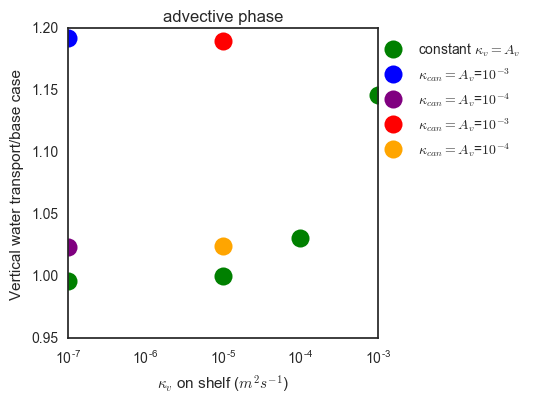

In [50]:
sns.set_context('notebook')
sns.set_style('white')

sns.set_palette('Set1',9)

labels = ['','','','constant $\kappa_v=A_v$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
          '$\kappa_{can}=A_v$=$10^{-3}$',
          '$\kappa_{can}=A_v$=$10^{-4}$',
         ]

colors = ['green','green','green','green','blue','purple','red','orange']

kv = [1E-7,1E-5,1E-4,1E-3,1E-7,1E-7,1E-5,1E-5]

trans_list = [advVert_flux43-advVert_flux50 ,
              advVert_flux38-advVert_flux42 ,
              advVert_flux37-advVert_flux41 ,
              advVert_flux36-advVert_flux40,
              advVert_flux013D-advVert_flux50,
              advVert_flux023D-advVert_flux50,
              advVert_flux033D-advVert_flux42,
              advVert_flux043D-advVert_flux42 ,
              ]
base = advVert_flux38-advVert_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,lab,color,kv_num in zip(trans_list,labels,colors,kv):
    ax.plot(kv_num,trans[:].mean()/base[:].mean(),'o',color=color,label=lab, markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$\kappa_v$ on shelf ($m^2s^{-1}$)')
ax.set_ylabel('Vertical water transport/base case')
ax.set_title('advective phase')

ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
fig.savefig('advVert_WatTrans_canyon_Kv_and_Av.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


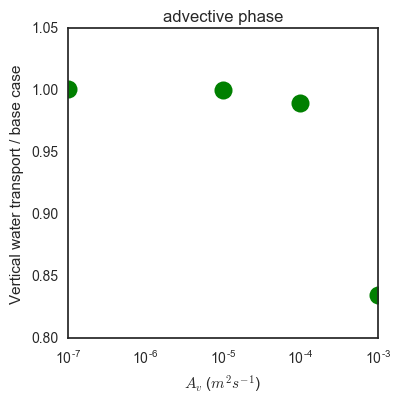

In [51]:
sns.set_context('notebook')
sns.set_style('white')


Av = [1E-7,1E-5,1E-4,1E-3]

trans_list = [advVert_flux55-advVert_flux58 ,
              advVert_flux38-advVert_flux42 ,
              advVert_flux56-advVert_flux59 ,
              advVert_flux57-advVert_flux60,
              ]
base = advVert_flux38-advVert_flux42 

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Av_num in zip(trans_list,Av):
    ax.plot(Av_num,trans[:].mean()/base[:].mean(),'go', markersize=13)

ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('$A_v$ ($m^2s^{-1}$)')
ax.set_ylabel('Vertical water transport / base case')
ax.set_title('advective phase')

fig.savefig('advVert_WatTransport_canyon_Av_only.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


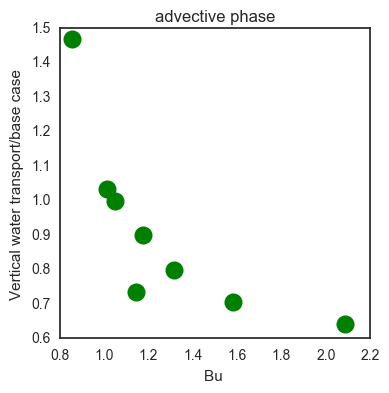

In [53]:
sns.set_context('notebook')
sns.set_style('white')

Hs = 152.5 # m
W = 8300.0 # m
N = np.array([5.5E-3,
              #3.9E-3,
              6.0E-3,
              #3.0E-3,
              5.5E-3,
              5.5E-3,
              #7.6E-3,
              4.5E-3,
              5.5E-3,
              5.5E-3,
              5.5E-3,
              ])

f = np.array([9.66E-5,
              #9.66E-5,
              9.66E-5,
              #9.66E-5,
              7.68E-5,
              4.84E-5,
              #9.66E-5,
              9.66E-5,
              1.0E-4,
              8.6E-5,
              6.4E-5])

Bu = (N*Hs)/(f*W)

trans_list = [advVert_flux38-advVert_flux42 ,
              #advVert_flux44-advVert_flux47 ,
              advVert_flux45-advVert_flux48 ,
              #advVert_flux46-advVert_flux49 ,
              advVert_flux51-advVert_flux53,
              advVert_flux52-advVert_flux54,
              #advVert_flux73-advVert_flux74,
              advVert_flux75-advVert_flux76,
              advVert_flux67-advVert_flux68,
              advVert_flux69-advVert_flux70,
              advVert_flux71-advVert_flux72,
              ]
base = advVert_flux38-advVert_flux42

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,Bu_num in zip(trans_list,Bu):
    ax.plot(Bu_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Bu ')
ax.set_ylabel('Vertical water transport/base case')
ax.set_title('advective phase')

fig.savefig('advVert_WatTransport_canyon_Bu.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


## Different forcing

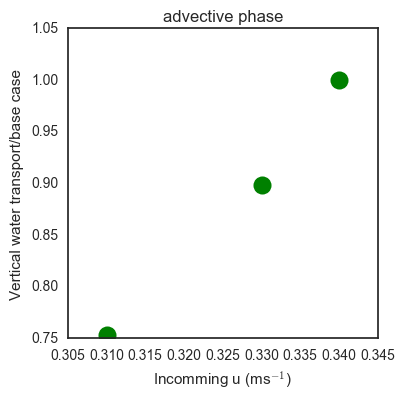

In [54]:
sns.set_context('notebook')
sns.set_style('white')

trans_list = [advVert_flux38,
              advVert_flux06,
              advVert_flux01,
              ]

base = advVert_flux38 
u_list = [0.34,0.33,0.31]

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean()/base[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('Vertical water transport/base case')
ax.set_title('advective phase')

fig.savefig('advVert_WatTransport_canyon_forcing.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')


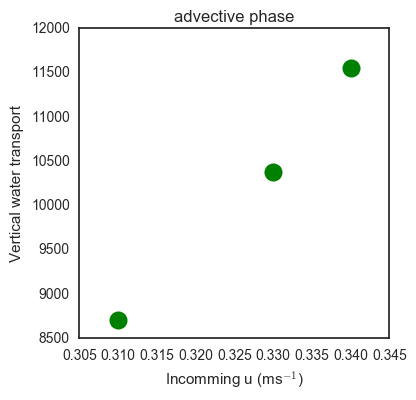

In [55]:
sns.set_context('notebook')
sns.set_style('white')

trans_list = [advVert_flux38,
              advVert_flux06,
              advVert_flux01,
              ]

base = advVert_flux38 
u_list = [0.34,0.33,0.31]

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,u_num in zip(trans_list,u_list):
    ax.plot(u_num,trans[:].mean(),'go', markersize=13)


ax.set_xlabel('Incomming u (ms$^{-1}$) ')
ax.set_ylabel('Vertical water transport')
ax.set_title('advective phase')

fig.savefig('advVert_WatTransport_canyon_forcing_absolute.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')

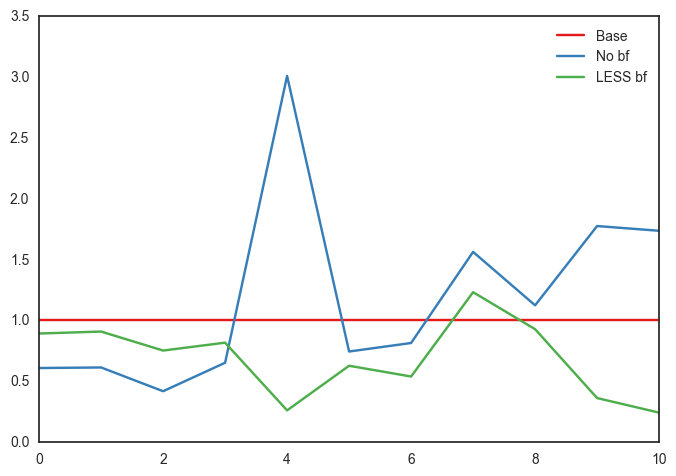

In [56]:
plt.plot(advVert_flux38/advVert_flux38,label='Base')

plt.plot(advVert_flux06/advVert_flux38,label='No bf')


plt.plot(advVert_flux01/advVert_flux38,label='LESS bf')



plt.legend(loc=0)

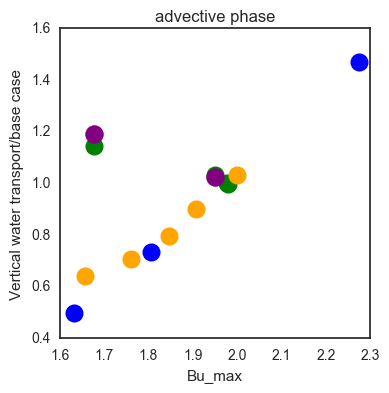

In [82]:
colors = ['g','g','g','g','b','b','b','orange','orange','orange','orange','orange','purple','purple','purple','purple']

# Constants and scales
L = 6400.0
U = 0.36
R = 5000.0
g=9.81
W = 13000
Hs = 150.0

Nos = np.array([5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                7.4E-3, 6.3E-3, 4.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,
               ])
fs = np.array([9.66E-5,9.66E-5,9.66E-5,9.66E-5,
               9.66E-5,9.66E-5,9.66E-5,
               1.0E-4,8.6E-5,7.68E-5,6.4E-5,4.84E-5,
               9.66E-5,9.66E-5,9.66E-5,9.66E-5])

kvs = np.array([1E-3,1E-4,1E-5,1E-7,
                1E-5,1E-5,1E-5,
                1E-5,1E-5,1E-5,1E-5,1E-5,
                1E-3,1E-4,1E-3,1E-4])

Dhs = fs*L/(Nos)
Zs =  (1.4*U*(L**(1/2)))/(Nos*(R**(1/2)))/2

t = 4.5*24*3600
Ktau = kvs*t/(Zs/1.8)**2

N_max = 0.2974*Nos*(Dhs/Zs)*(1-Ktau)+0.007342

Adv_T = [advVert_flux36,advVert_flux37,advVert_flux38,advVert_flux43,
         advVert_flux73,advVert_flux45,advVert_flux75,
         advVert_flux67,advVert_flux69,advVert_flux51,advVert_flux71,advVert_flux52,
         advVert_flux013D,advVert_flux023D,advVert_flux033D,advVert_flux043D]

Bu_mod = N_max*W/(fs*L)
Bu = Nos*W/(fs*L)

fig,ax = plt.subplots(1,1,figsize=(4,4))
for trans,bb,cc in zip(Adv_T,Bu_mod/Bu,colors):
    ax.plot(bb,trans[:].mean()/base[:].mean(),'o',color=cc, markersize=13)


ax.set_xlabel('Bu_max')
ax.set_ylabel('Vertical water transport/base case')
ax.set_title('advective phase')

fig.savefig('advVert_WatTransport_canyon_Bu_Nmax.eps',format='eps',transparent=True,frameon=False,bbox_inches='tight')
